# CLIPme if you can!

In [1]:
# install clip
!pip install clip-by-openai

     |████████████████████████████████| 1.4 MB 8.5 MB/s 
     |████████████████████████████████| 776.8 MB 15 kB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 12.8 MB 20.4 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.7.1 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.7.1 which is incompatible.


In [2]:
import torch
import clip
from PIL import Image
import numpy
import cv2
from google.colab.patches import cv2_imshow
import requests
from io import BytesIO

In [3]:
# init clip
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|██████████████████████| 353976522/353976522 [00:02<00:00, 175206270.02it/s]


Specify the URL of the image and the names of the subjects you want to query in the image.

Select one example:

In [4]:
# EXAMPLE 1
queries = ["Albert Einstein", "Marie Curie", "Max Planck", "Paul Dirac", "Lorentz", "Niels Bohr"]
image_url = "https://i.redd.it/okqe57386di51.jpg"
face_detector_scale = 1.2 # smaller images need smaller scaling (less downscaling -> more faces are detected)

In [ ]:
# EXAMPLE 2
#queries = ["Angela Merkel", "Joe Biden", "Boris Johnson", "Macron", "Justin Trudeau"]
queries = ["Germany", "Great Britain", "France", "Japan", "Canada"]
image_url = "https://www.tagesschau.de/multimedia/bilder/g7-121~_v-gross20x9.jpg"
face_detector_scale = 1.01 # faces are tiny

In [ ]:
# EXAMPLE 3
queries = ["Angela Merkel", "Olaf Scholz", "Justus Thies", "Matthias Niessner"]
image_url = "https://justusthies.github.io/posts/face_berlin/thumb.jpg"
face_detector_scale = 1.4 # large image, larger downsampling scale

In [ ]:
# EXAMPLE 4
queries = ["Akihiko Shirai", "Justus Thies", "Mike Seymour"]
image_url = "https://pbs.twimg.com/media/D5fal0cWsAQxpCT?format=jpg"
face_detector_scale = 1.2 # smaller images need smaller scaling (less downscaling -> more faces are detected)

Load and display image.

In [5]:
# load image
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
original_image = numpy.asarray(img)

#cv2_imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

Detect faces in the input image.

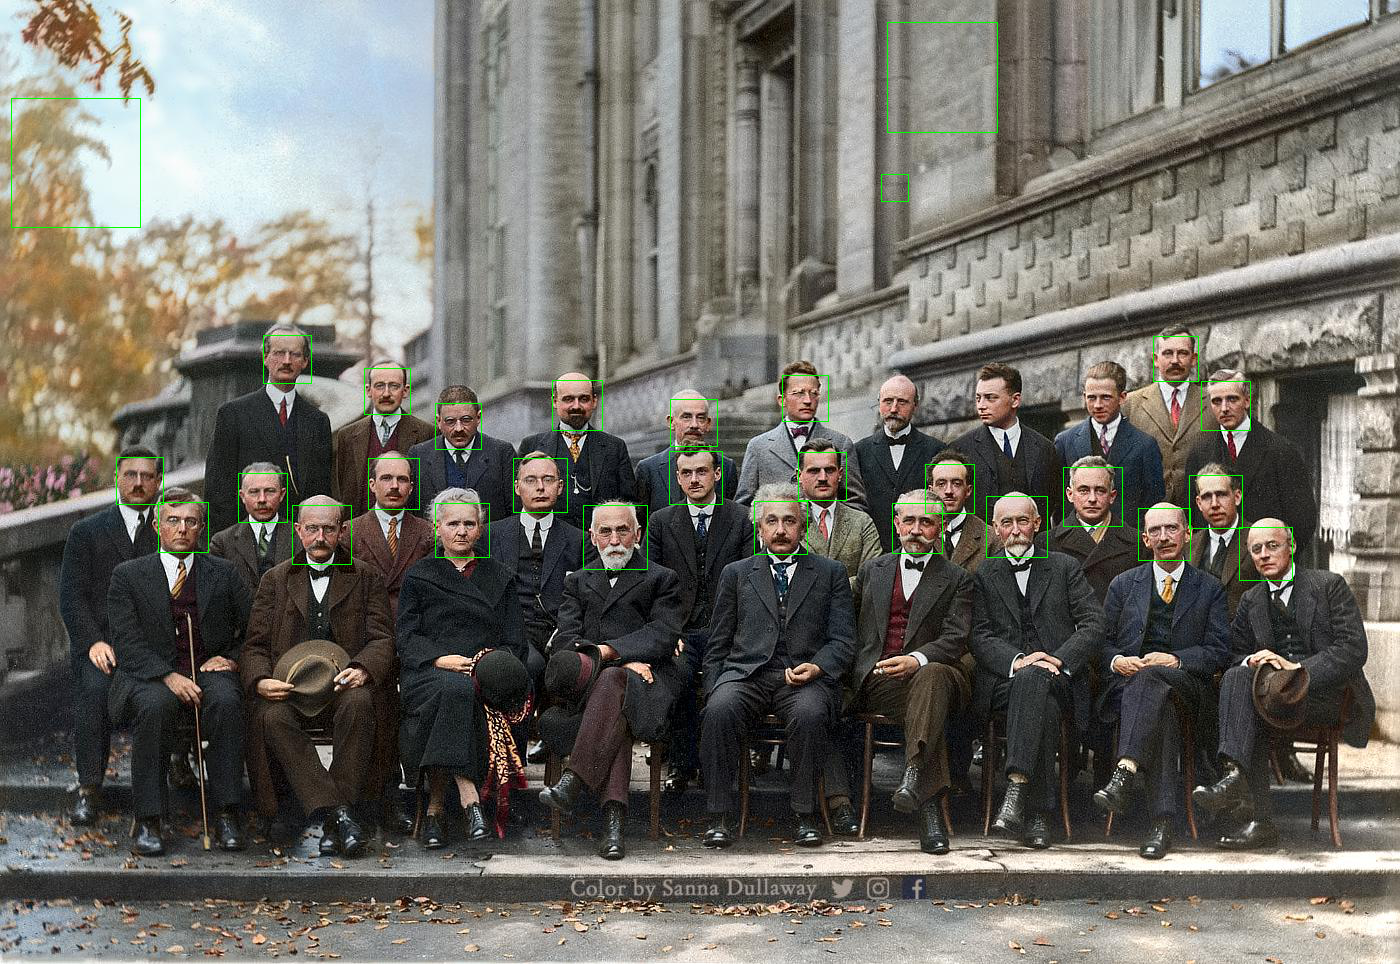

In [6]:
# detect faces
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
faces =  face_cascade.detectMultiScale(gray, face_detector_scale, 4)

detections_img = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
for (x, y, w, h) in faces: 
  cv2.rectangle(detections_img,(x,y),(x+w,y+h),(0,255,0),1)
cv2_imshow(detections_img)

Run CLIP on the cropped face images.

In [7]:
# tokenize queries
text = clip.tokenize(queries).to(device)

# assign names to faces
with torch.no_grad():    
    max_crop = text.shape[0]*[0]
    best_crop = text.shape[0]*[None]
    
    for (x, y, w, h) in faces:   
        cropped_image = preprocess(Image.fromarray(original_image[y:y+h, x:x+w])).unsqueeze(0).to(device)
        logits_per_image, logits_per_text = model(cropped_image, text)
        decider = logits_per_image.cpu().numpy()   
        for j in range(0,text.shape[0]):
            if max_crop[j] < decider[0][j]:
                max_crop[j] = decider[0][j]
                best_crop[j] = (x,y,w,h)

Output the annotated image as well as the crops.

Albert Einstein :  (754, 501, 53, 53)


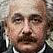

Marie Curie :  (435, 503, 54, 54)


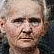

Max Planck :  (292, 505, 59, 59)


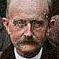

Paul Dirac :  (669, 451, 53, 53)


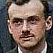

Lorentz :  (986, 496, 61, 61)


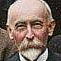

Niels Bohr :  (1189, 475, 53, 53)


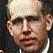

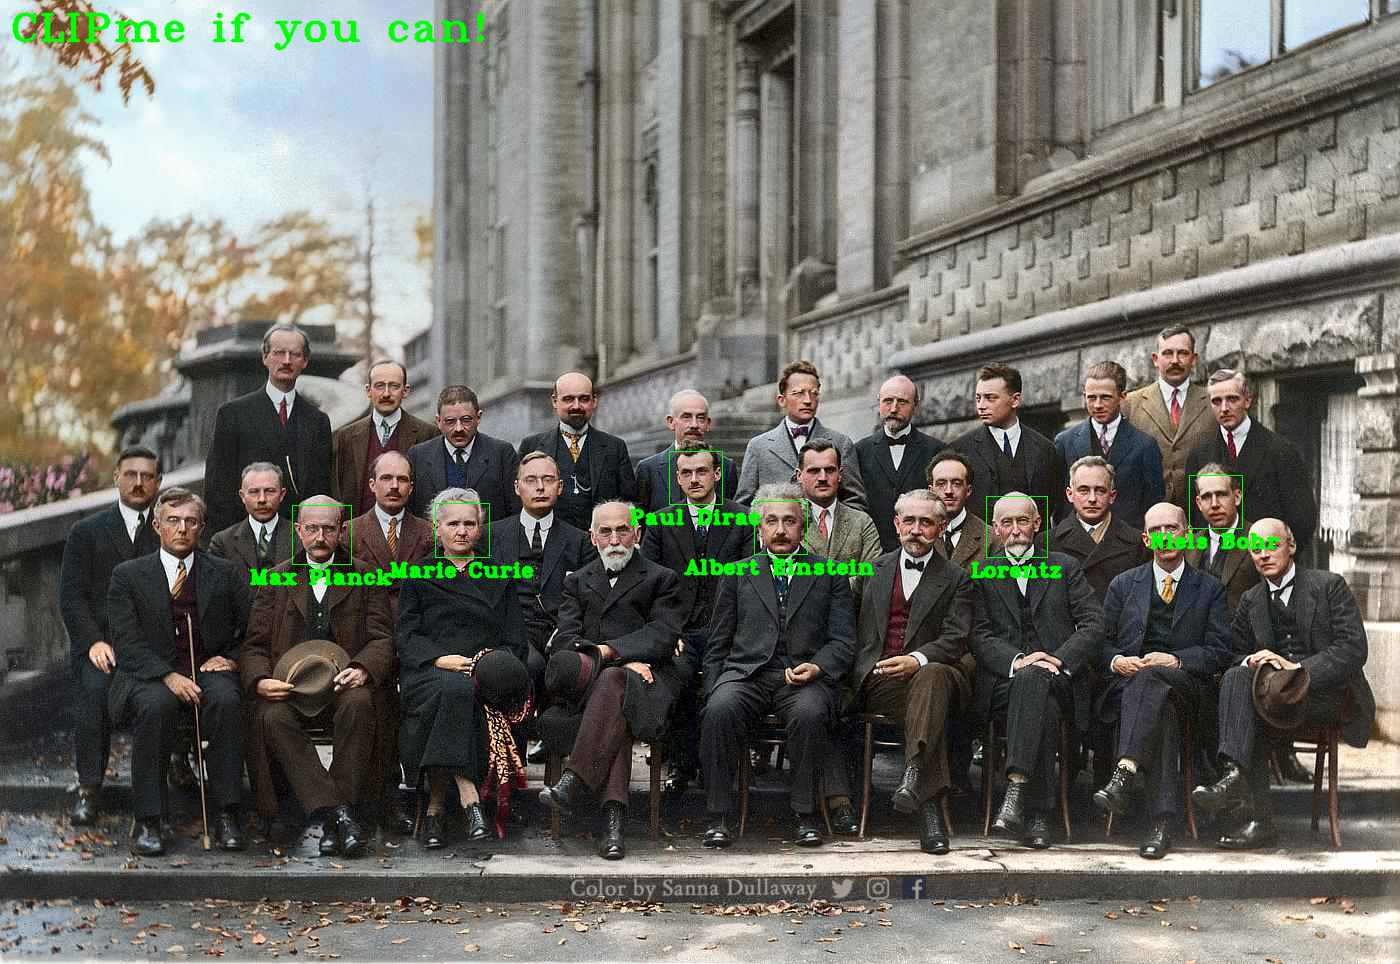

In [8]:
with torch.no_grad():
    # output crops
    for j in range(0,text.shape[0]): 
        print(queries[j], ': ', best_crop[j])
        x,y,w,h = best_crop[j]
        img = original_image[y:y+h, x:x+w]
        cv2_imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    # output annotated image
    opencv_img = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    font = cv2.FONT_HERSHEY_COMPLEX_SMALL #FONT_HERSHEY_PLAIN
    cv2.putText(opencv_img,"CLIPme if you can!",(10,40), font, 2, (0, 255, 0), 2, cv2.LINE_AA)
    for j in range(0,text.shape[0]):
      x,y,w,h = best_crop[j]
      cv2.rectangle(opencv_img,(x,y),(x+w,y+h),(0,255,0),1)
      textsize = cv2.getTextSize(queries[j], font, 1, 2)[0]
      cv2.putText(opencv_img,queries[j],(x+w//2-textsize[0]//2,y+h+textsize[1]+5), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
    print('\n')
    cv2_imshow(opencv_img)